In [1]:
! pip install gym
! pip install highway-env

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import gym
import highway_env
from collections import deque
import matplotlib.pyplot as plt
import scipy.stats as st


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
env = gym.make("highway-v0")

C:\Users\Nikoo\AppData\Roaming\Python\Python38\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


In [10]:
import pprint
pprint.pprint(env.config)

{'action': {'type': 'DiscreteMetaAction'},
 'centering_position': [0.3, 0.5],
 'collision_reward': -1,
 'controlled_vehicles': 1,
 'duration': 40,
 'ego_spacing': 2,
 'high_speed_reward': 0.4,
 'initial_lane_id': None,
 'lane_change_reward': 0,
 'lanes_count': 4,
 'manual_control': False,
 'normalize_reward': True,
 'observation': {'type': 'Kinematics'},
 'offroad_terminal': False,
 'offscreen_rendering': False,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'policy_frequency': 1,
 'real_time_rendering': False,
 'render_agent': True,
 'reward_speed_range': [20, 30],
 'right_lane_reward': 0.1,
 'scaling': 5.5,
 'screen_height': 150,
 'screen_width': 600,
 'show_trajectories': False,
 'simulation_frequency': 15,
 'vehicles_count': 50,
 'vehicles_density': 1}


In [4]:
env.action_space

Discrete(5)

In [5]:
env.observation_space

Box(-inf, inf, (5, 5), float32)

In [11]:
env.reset()

(array([[ 1.        ,  0.89754343,  0.25      ,  0.3125    ,  0.        ],
        [ 1.        ,  0.11422133,  0.5       , -0.0148753 ,  0.        ],
        [ 1.        ,  0.21084076,  0.25      , -0.04325522,  0.        ],
        [ 1.        ,  0.31310144,  0.        , -0.03263571,  0.        ],
        [ 1.        ,  0.42166647, -0.25      , -0.03957684,  0.        ]],
       dtype=float32),
 {'speed': 25,
  'crashed': False,
  'action': 3,
  'rewards': {'collision_reward': 0.0,
   'right_lane_reward': 0.3333333333333333,
   'high_speed_reward': 0.5,
   'on_road_reward': 1.0}})

In [7]:
env.action_space

Discrete(5)

C:\Users\Nikoo\AppData\Roaming\Python\Python38\site-packages\gym\utils\passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(
C:\Users\Nikoo\AppData\Roaming\Python\Python38\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


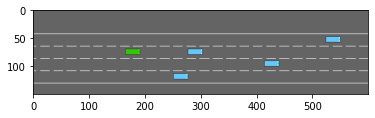

: 

In [10]:
%matplotlib inline

env = gym.make('highway-v0')
env.reset()
for _ in range(3):
    action = env.action_type.actions_indexes["IDLE"]
    obs, reward, done, info,_ = env.step(action)
    env.render()

plt.imshow(env.render(mode="rgb_array"))
plt.show()

In [17]:
def save_checkpoint(state, filename):
    model_save_name = filename
    path = F"/content/drive/My Drive/{model_save_name}" 
    print("=> Saving checkpoint")
    torch.save(state, path)


def load_checkpoint(checkpoint,model):
    print("=> Loading checkpoint")
    #model.load_state_dict(checkpoint["state_dict"])
    rewards_per_run = checkpoint["rewards_per_run"]
    return rewards_per_run


In [26]:
def plott(num_episode, Sum_Rewards, Sum_Rewards_w, num_run, title):
  
  def Caculate_CI_and_Error(num_episode, Sum_Rewards, num_run) :
    error_list = []
    mean_list = []
    df = num_run - 1
    for i in range(num_episode):
      arr = np.array(Sum_Rewards)[:,i]
      x_bar = np.mean(arr)
      s = np.std(arr)
      se = s/np.sqrt(num_episode)
      t_star = st.t.ppf(0.025, df)
      CI_up = x_bar + (t_star*se)
      error_list.append(CI_up-x_bar)
      mean_list.append(x_bar)
    return mean_list, error_list


  mean_list, error_list = Caculate_CI_and_Error(num_episode, Sum_Rewards, num_run)
  mean_list_w, error_list_w = Caculate_CI_and_Error(num_episode, Sum_Rewards_w, num_run)

  plt.figure(figsize=(30,8))
  plt.plot(range(1,num_episode+1), mean_list, 'k-', color='#1B2ACC',label = "without transferred weights")
  plt.fill_between(range(1,num_episode+1), np.array(mean_list)-np.array(error_list), np.array(mean_list)+np.array(error_list),alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.plot(range(1,num_episode+1), mean_list, 'k-', color='#CC4F1B',label = 'with transferred weights')
  plt.fill_between(range(1,num_episode+1), np.array(mean_list_w)-np.array(error_list_w), np.array(mean_list_w)+np.array(error_list_w),alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
  plt.xlabel("Episode")
  plt.ylabel("MeanReward")
  plt.legend()
  plt.title(title)
  plt.show();
  


In [14]:
def plottt(num_episode, Sum_Rewards, num_run, title):
  
  def Caculate_CI_and_Error(num_episode, Sum_Rewards, num_run) :
    error_list = []
    mean_list = []
    df = num_run - 1
    for i in range(num_episode):
      arr = np.array(Sum_Rewards)[:,i]
      x_bar = np.mean(arr)
      s = np.std(arr)
      se = s/np.sqrt(num_episode)
      t_star = st.t.ppf(0.025, df)
      CI_up = x_bar + (t_star*se)
      error_list.append(CI_up-x_bar)
      mean_list.append(x_bar)
    return mean_list, error_list


  mean_list, error_list = Caculate_CI_and_Error(num_episode, Sum_Rewards, num_run)

  plt.figure(figsize=(30,8))
  plt.plot(range(1,num_episode+1), mean_list, 'k-', color='#1B2ACC')
  plt.fill_between(range(1,num_episode+1), np.array(mean_list)-np.array(error_list), np.array(mean_list)+np.array(error_list),alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
  plt.xlabel("Episode")
  plt.ylabel("MeanReward")
  plt.title(title)
  plt.show();
  


# policy network

In [9]:
# define policy network
class policy_net(nn.Module):
  # nS: state space size, nH: n. of neurons in hidden layer, nA: size action space
    def __init__(self, nS, nH, nA): 
        super(policy_net, self).__init__()
        self.h = nn.Linear(nS, nH)
        self.out = nn.Linear(nH, nA)

    # define forward pass with one hidden layer with ReLU activation and sofmax after output layer
    def forward(self, x):
        x = F.relu(self.h(x))
        x = F.softmax(self.out(x), dim=1)
        return x

# training function

In [10]:
def training (env_name, gamma, num_episode, num_run, path_name , pre_train):

  rewards_per_run = []
  
  
  for i in range(num_run):


    # instantiate

    rewards_per_episode = []
    
    env = gym.make(env_name)

    # instantiate the policy
    policy = policy_net(env.observation_space.shape[0]*5, 20, env.action_space.n)

    if pre_train == True :
      policy.load_state_dict(torch.load(path_name))

    # create an optimizer
    optimizer = torch.optim.Adam(policy.parameters())
    sum_rewards = deque(maxlen=100)
    
    print("------------- Run: {} ---------------".format(i+1))

    
    for e in range(num_episode):

      
      rewards = []
      actions = []
      states  = []
        
      # reset environment
      state, _ = env.reset()
      while True:

        # calculate probabilities of taking each action
        probs = policy(torch.tensor(state.flatten()).unsqueeze(0).float())
        # sample an action from that set of probs
        sampler = Categorical(probs)
        action = sampler.sample()

        new_state, reward, done,_,_ = env.step(action.item())
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = new_state
        if done:
          break

      # preprocess rewards
      rewards = np.array(rewards)
      # calculate rewards to go for less variance
      R = torch.tensor([np.sum(rewards[i:]*(gamma**np.array(range(i, len(rewards))))) for i in range(len(rewards))])
      
      # preprocess states and actions
      states = torch.tensor(states).float()
      actions = torch.tensor(actions)

      # calculate gradient
      probs = policy(states.flatten(1))
      sampler = Categorical(probs)
      log_probs = -sampler.log_prob(actions)  
      loss = torch.sum(log_probs * R)
      # update policy weights
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # calculate average return and print it out
      sum_rewards.append(np.sum(rewards))
      rewards_per_episode.append(np.mean(sum_rewards))
      if e %200 == 0:
        print("Episode:{:2d}\tAvg.reward: {:6.2f}".format(e, np.mean(sum_rewards)))
        
    rewards_per_run.append(rewards_per_episode)
    # close environment
    env.close()

  checkpoint = {'state_dict' : policy.state_dict(),
                  'rewards_per_run' : rewards_per_run 
                  }
  save_checkpoint(checkpoint, filename= checkpoint_name)

  return rewards_per_run, policy

# hyperparameters

In [11]:
gamma=0.99
num_episode = 1000
num_run = 5

# merge task



In [ ]:
# merge_task
env_name = "merge-v0"
rewards_run_merge, model_merge = training (env_name, gamma, num_episode, num_run, path_name = "", pre_train = False)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


------------- Run: 1 ---------------


<ipython-input-4-0e45af86b9e8>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  states = torch.tensor(states).float()


Episode: 0	Avg.reward:  12.86
Episode:200	Avg.reward:  11.04
Episode:400	Avg.reward:  10.78
Episode:600	Avg.reward:  10.62
Episode:800	Avg.reward:  11.24
------------- Run: 2 ---------------
Episode: 0	Avg.reward:  11.47
Episode:200	Avg.reward:  11.02
Episode:400	Avg.reward:  10.68
Episode:600	Avg.reward:  10.86
Episode:800	Avg.reward:  10.93
------------- Run: 3 ---------------
Episode: 0	Avg.reward:  11.86
Episode:200	Avg.reward:  10.89
Episode:400	Avg.reward:  10.72
Episode:600	Avg.reward:  10.64
Episode:800	Avg.reward:  11.24
------------- Run: 4 ---------------
Episode: 0	Avg.reward:   9.12
Episode:200	Avg.reward:  10.54
Episode:400	Avg.reward:  10.47
Episode:600	Avg.reward:  10.78
Episode:800	Avg.reward:  10.94
------------- Run: 5 ---------------
Episode: 0	Avg.reward:  12.86
Episode:200	Avg.reward:  10.94
Episode:400	Avg.reward:  10.68
Episode:600	Avg.reward:  11.13
Episode:800	Avg.reward:  11.07


In [ ]:
torch.save(model_merge.state_dict(), 'merge_weights.pth')

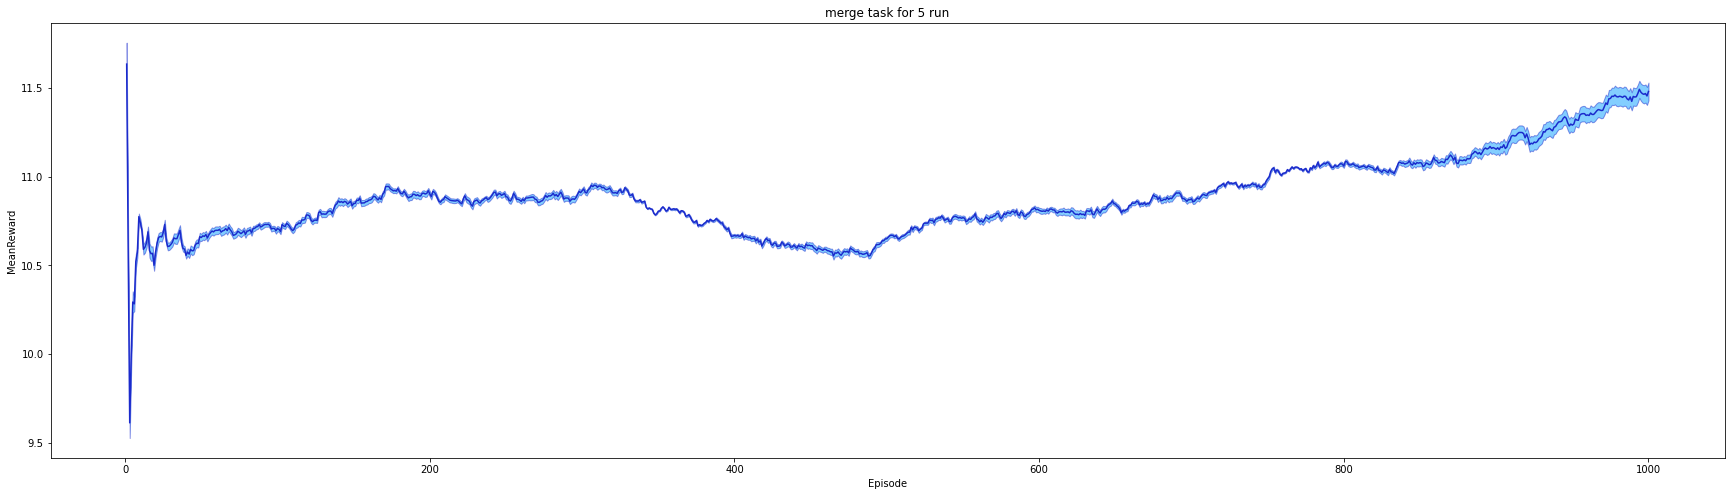

In [ ]:
plottt(num_episode, rewards_run_merge, num_run, "merge task for 5 run")


 # highway task without transferred weights

In [ ]:
# highway_task without transferred weights
checkpoint_name = "my_checkpoint_rl_highway.pth.tar"
env_name = "highway-fast-v0"
rewards_run_highway, model_highway = training(env_name, gamma, num_episode, num_run, path_name = '', pre_train = False)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


------------- Run: 1 ---------------
Episode: 0	Avg.reward:  12.00
Episode:200	Avg.reward:  10.88
Episode:400	Avg.reward:  14.60
Episode:600	Avg.reward:  17.32
Episode:800	Avg.reward:  16.74
------------- Run: 2 ---------------
Episode: 0	Avg.reward:   5.42
Episode:200	Avg.reward:  10.13
Episode:400	Avg.reward:  18.65
Episode:600	Avg.reward:  19.64
Episode:800	Avg.reward:  21.10
------------- Run: 3 ---------------
Episode: 0	Avg.reward:  21.22
Episode:200	Avg.reward:  11.85
Episode:400	Avg.reward:  18.75
Episode:600	Avg.reward:  20.21
Episode:800	Avg.reward:  20.22
------------- Run: 4 ---------------
Episode: 0	Avg.reward:  19.50
Episode:200	Avg.reward:  11.18
Episode:400	Avg.reward:  16.45
Episode:600	Avg.reward:  16.45
Episode:800	Avg.reward:  16.96
------------- Run: 5 ---------------
Episode: 0	Avg.reward:   2.18
Episode:200	Avg.reward:  10.94
Episode:400	Avg.reward:  16.24
Episode:600	Avg.reward:  19.63
Episode:800	Avg.reward:  18.78
=> Saving checkpoint


# highway task with transferred weights

In [12]:
# highway_task with transferred weights
checkpoint_name = "my_checkpoint_rl_highway_with.pth.tar"
env_name = "highway-fast-v0"
rewards_run_highway_w, model_highway_w = training (env_name, gamma, num_episode, num_run, path_name = 'merge_weights.pth', pre_train = True)

/usr/local/lib/python3.8/dist-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (5, 5)
  logger.warn(


------------- Run: 1 ---------------
Episode: 0	Avg.reward:   9.33
Episode:200	Avg.reward:  13.16
Episode:400	Avg.reward:  16.51
Episode:600	Avg.reward:  15.73
Episode:800	Avg.reward:  17.17
------------- Run: 2 ---------------
Episode: 0	Avg.reward:   8.10
Episode:200	Avg.reward:  11.31
Episode:400	Avg.reward:  15.40
Episode:600	Avg.reward:  17.00
Episode:800	Avg.reward:  19.46
------------- Run: 3 ---------------
Episode: 0	Avg.reward:   6.63
Episode:200	Avg.reward:  13.27
Episode:400	Avg.reward:  17.05
Episode:600	Avg.reward:  17.99
Episode:800	Avg.reward:  18.81
------------- Run: 4 ---------------
Episode: 0	Avg.reward:   4.15
Episode:200	Avg.reward:  11.36
Episode:400	Avg.reward:  18.39
Episode:600	Avg.reward:  18.69
Episode:800	Avg.reward:  20.07
------------- Run: 5 ---------------
Episode: 0	Avg.reward:  22.15
Episode:200	Avg.reward:  14.05
Episode:400	Avg.reward:  16.77
Episode:600	Avg.reward:  17.23
Episode:800	Avg.reward:  18.00
=> Saving checkpoint


In [24]:
checkpoint_name = "my_checkpoint_rl_highway.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
rewards_highway = load_checkpoint(torch.load(path),_)



=> Loading checkpoint


In [23]:
checkpoint_name = "my_checkpoint_rl_highway_with.pth.tar"
path = F"/content/drive/My Drive/{checkpoint_name}" 
rewards_highway_t = load_checkpoint(torch.load(path),_)

=> Loading checkpoint


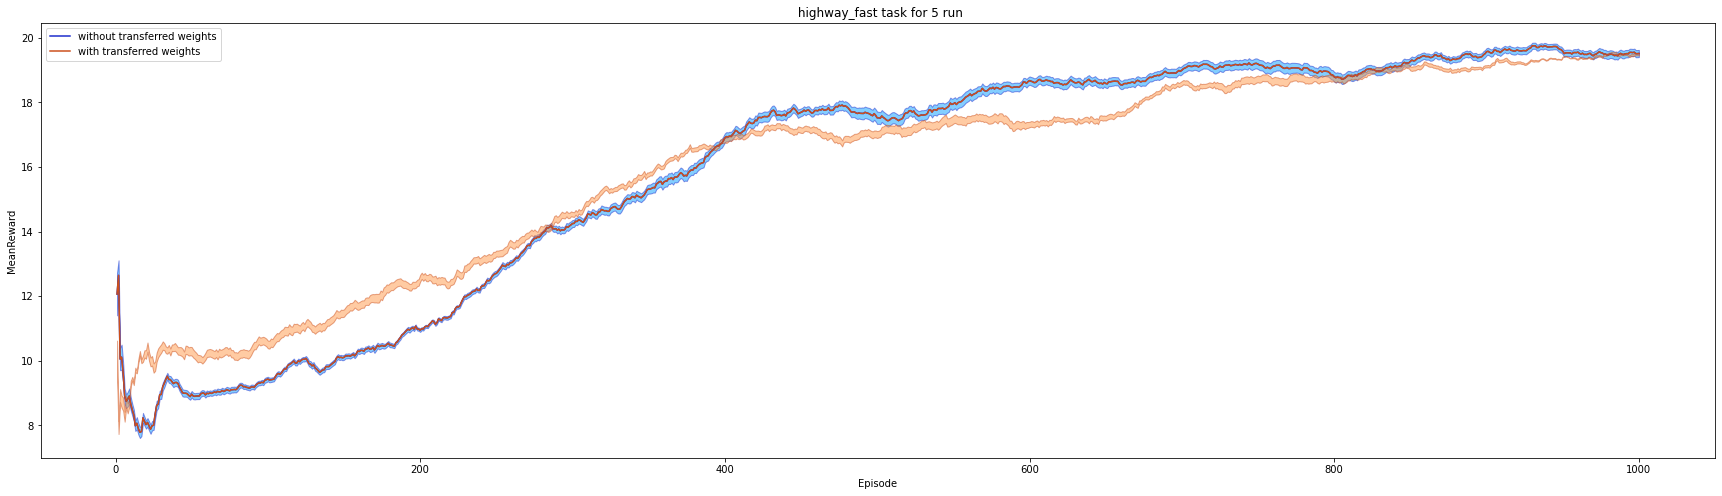

In [27]:
plott(num_episode, rewards_highway, rewards_highway_t, num_run, " highway_fast task for 5 run")